# Predicting the Failure Rate of Kickstarter projects

#### David Collins, Nathan Rosenberg

# Introduction

Kickstarter is a public crowdfunding platform where users can set up campaigns to raise money for their project or idea. The company's stated mission is to "help bring creative projects to life". While many of these ideas go on to become wildly successful commercial retail products or services, not all make the cut, with many projects failing the raise the needed captial in their alotted time to reach their fundraising goal. This project aims to explore why these Kickstarter projects fail and see if we can derive some insight as to why certain projects succeed while others fail. 

Using detailed data from the website Kaggle, we were able to aggregate and explore hundreds of thousands of Kickstarter projects from the past few years in an attempt to see what makes a successful Kickstarter project.

## Necessary Packages and Other Resources

For this project, along with Python 3, we used a number of other libraries including [pandas](https://pandas.pydata.org/pandas-docs/stable/), [numpy](https://docs.scipy.org/doc/numpy/user/), [matplotlib](https://matplotlib.org/contents.html), [scikit-learn](https://scikit-learn.org/stable/index.html), [seaborn](https://seaborn.pydata.org/), [statsmodels](https://www.statsmodels.org/stable/index.html), and [datetime](https://docs.python.org/2/library/datetime.html)

In [276]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from statsmodels import api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Data Wrangling

We loaded the data from the .csv file from Kaggle given [here](https://www.kaggle.com/kemical/kickstarter-projects/data#ks-projects-201801.csv). We used dataset 'ks-projects-201801.csv' because it contained more up to date data and wanted to use as much data as possible. 

To load the file we had to use latin-1 encoding because utf-8, the default encoding for pandas can't encode certain characters (\x99 byte) that were present in the CSV

In [233]:
# Read all of data from CSV file into a pandas dataframe
k_d = pd.read_csv('data.csv', encoding = 'latin-1')

#print the first five rows of the data set
k_d.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


<br>

Next, we wanted to start cleaning up the data so that we can begin doing analysis on it. We first looked at the different states of the kickstarter projects to look for a way that we can classify then into either successes or failures.

In [127]:
print(k_d['state'].unique())

['failed' 'canceled' 'successful' 'live' 'undefined' 'suspended']


Since we can see that there are many more different states that are given in the dataset than just success or failure, we added an extra column to the end of the dataset called 'successful' which classifies whether the project failed or not. We classified that the states 'failed', 'cancelled' and 'suspended' all as failing projects. Furthermore, we chose to drop live rows since they can't necessarily be judged one way or another, we also dropped all the undefined rows since they contained missing data and we were unable to tell the status of them.

In [234]:
# Removing all the rows that have the state of undefined or live
k_d = k_d[k_d['state'] != 'undefined']
k_d = k_d[k_d['state'] != 'live']


# Add a column to the end of the dataframe and tag each row whether it was a success or failure 
# 1 = success, 0 = failure
k_d["successful"] = 0
k_d.loc[k_d['state'] == 'successful', 'successful'] = 1

#Removing columns not necessary for this project
k_d = k_d.drop(['name', 'currency', 'goal', 'pledged', 'usd pledged', 'state', 'backers', 'country'], axis=1)

k_d.head()

,ID,category,main_category,deadline,launched,usd_pledged_real,usd_goal_real,successful
0,1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,0.0,1533.95,0
1,1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,2421.0,30000.00,0
2,1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,220.0,45000.00,0
3,1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,1.0,5000.00,0
4,1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,1283.0,19500.00,0


# Data Exploration and Analysis

## Overall Failure Rates

First we wanted to look at the overall failure rates of projects on Kickstarter to get a basis of what the failure rate overall looks like for projects. 

In [235]:
# Group all the rows by whether they were marked as successful or not and count the amount of each grouping
failure_split = k_d.groupby('successful')['successful'].count()
failure_split

successful
0    238344
1    133956
Name: successful, dtype: int64

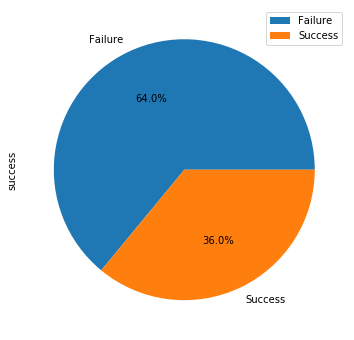

In [236]:
# Plot the percentages of the total successes and failures relative to the total amount of entries in the data set
overall = pd.DataFrame({'success': failure_split.values}, index=['Failure', 'Success'])
plot = overall.plot.pie(y='success', figsize=(6, 6), autopct='%1.1f%%')

So from this pie chart we can see that slightly over 1/3rd of projects from our Kickstarter dataset end up unsuccessful in one way or another. We are going to breakdown some of the key data points about each of these kickstarter projects in order to try to gain an in depth understanding of how each of these categories factor into the failure rate of Kickstarter projects as well as to see which of these different categories plays the highest role in the success or failure of a kickstarter project.

<br>

## Category Breakdown

The first possible predictor of failure of a Kickstarter project that we want to look at is the category of the project. Each of the Kickstarter projects was broken down into 1 of 15 main catgories, and then further broken down into a more specific subcategory within that main category. First we want to look at which categories had the highest percentage of successful projects.

In [237]:
# Group the data set by the main category, and count the amount of projects that were listed under that category
category_totals = k_d.groupby('main_category')['main_category'].count().sort_values()
category_totals

main_category
Dance            3749
Journalism       4724
Crafts           8733
Photography     10730
Comics          10743
Theater         10871
Fashion         22563
Food            24418
Art             27959
Design          29763
Technology      32189
Games           34943
Publishing      39113
Music           49403
Film & Video    62399
Name: main_category, dtype: int64

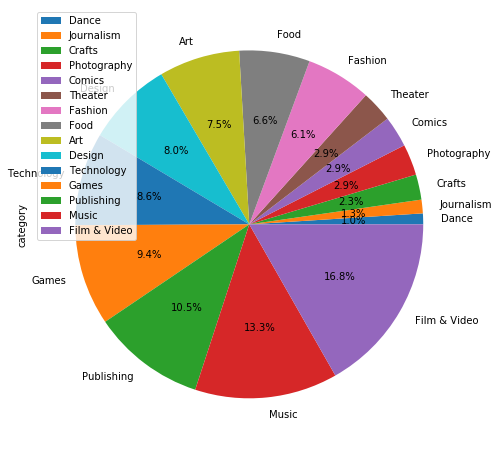

In [238]:
# Create a pie chart of the percentage that each of the 15 categories makes up of the total set of projects
overall = pd.DataFrame({'category': category_totals})
plot = overall.plot.pie(y='category', figsize=(8, 8), autopct='%1.1f%%')

So we can see from this graph that there is a pretty big disparity in the percentage breakdown of the different categories, with only 4 categories making up close to 50% of all projects on Kickstarter. Some of the categories only took up small amounts of the total projects on Kickstarter, like Dance and crafts, making up 1% and 2.3% respectively, and other making up significiantly larger percentages of the projects on kickstarter, such as Film and Video, and Music, with 16.8% and 13.3% respectively.

## Category vs Failure Rate

After looking at the breakdown of the categories of the projects, we now want to explore if there is a relationship between the category of the project and the failure rate.

In [274]:
# Group the data set by the main category, and whether they were successful or not 
# and count the amount of each
category_counts = k_d.groupby(['main_category'], as_index=False)['successful'].sum()
category_totals = k_d.groupby(['main_category'], as_index=False)['successful'].count()
category_pct = category_totals.drop(['successful'], axis=1)
# Then add a success rate by divding total successful projects by total projects in that grouping
category_pct['success_rate'] = (pd.to_numeric(category_counts['successful']) \
                                / pd.to_numeric(category_totals['successful'])) * 100
category_pct = category_pct.sort_values(["success_rate"])
category_pct.head()

,main_category,success_rate
13,Technology,19.988195
9,Journalism,21.422523
2,Crafts,24.218482
5,Fashion,24.788370
7,Food,24.920141


After creating a table of the success rates of each individual category, now we can create a plot to see how the different categories stack up against one another in terms of their success rate.

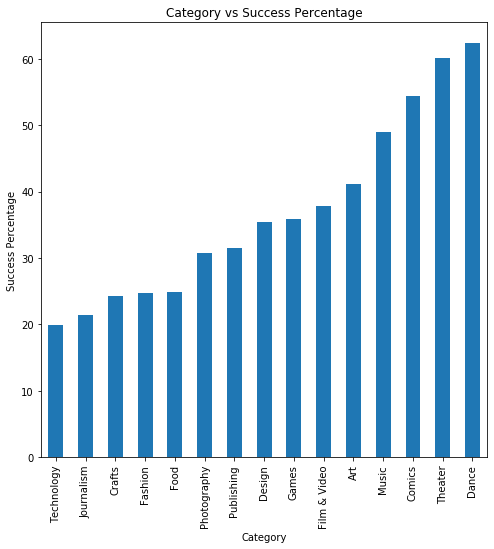

In [275]:
plot = category_pct["success_rate"].plot(kind='bar', figsize=(8,8), title="Category vs Success Percentage")
plot.set_xlabel('Category')
plot.set_ylabel('Success Percentage')
plt.xticks(np.arange(15), category_pct["main_category"])
plt.show()

So from this graph we can see that Dance and Theatre had the highest success rate of all the main categories, with photography and comics being slightly below them. This was interesting to see because as you can see from the previous pie chart, theatre and dance were two of the lowest categories in terms of percentages of all Kickstarter projects. This is an interesting development is it may lead to the conclusion that while, they may make up a very small percentage of Kickstarter projects, these categories overall are much more successful, meanwhile some of the categories that are more popular fail much more often. 

One potential explanation for this is that those categories are often more niche on the site and so they are more likely to get picked up by a third party and get the attention needed to reach their funding goals. However one thing that can be noted is that Music comes in as the 4th most successful category of Kickstarter project, even while being the second most popular main category of campaigns on the site. Furthermore, Film & Video comes in 6th place overall for most successful category where it is the 1st most popular category on the site. 

Another possibility to explain why certain categories experience a higher failure rate than others is that those categories may have a higher average funding goal than others, making it harder projects in that category to reach their funding goal and thus have an overall lower success rate. So while it seems that Dance and Theatre have the highest success rates, you also may want to consider the other factors that we explore below.

## Campaign length vs Failure Rate

Another possible predictor of failure rate is campaign length, so we'd like to see if we should explore a relationship between campaign length and failure rate. Since our dataset only gives us the launch date and deadline in string format, in order to get a quantitative campaign length we converted the launch date and deadline into datetime objects, found the difference between them, and added a new column for campaign length.

In [138]:
#Create a new column for campaign length
k_d['campaign_length'] = 0
#For each row convert the launch date and deadline into datetime objects, then set the campaign length to the difference
#between the two
for i, row in k_d.iterrows():
    deadline = dt.strptime(row['deadline'], '%Y-%m-%d')
    launched = dt.strptime(row['launched'], '%Y-%m-%d %H:%M:%S')
    k_d.at[i, 'campaign_length'] = int((deadline - launched).days)
k_d.head()

,ID,category,main_category,deadline,launched,usd_pledged_real,usd_goal_real,successful,campaign_length
0,1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,0.0,1533.95,0,58
1,1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,2421.0,30000.00,0,59
2,1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,220.0,45000.00,0,44
3,1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,1.0,5000.00,0,29
4,1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,1283.0,19500.00,0,55


In order to get a useful visual representation of the campaign length vs failure rate, we decided to split the dataset into bins based on campaign length, so that we could compare the failure rates of each bin and try to find a relationship between each bin's campaign length group and failure rate. We did our best to group them with even amounts of data points in each bin, with about 40,000 entries in each bin, however campaigns with a duration of 28 days are so common that they need their own bin, and still have more than triple the data points that the other bins have. Because there is no point in analyzing data points with the same campaign length seperately, we will move forward with all the bins being about even size except the 28 days bin, and will keep in mind the extra data points in that bin when we analyze the results.

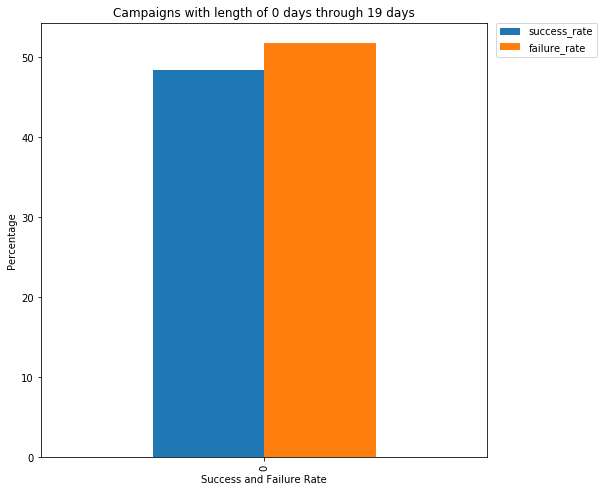

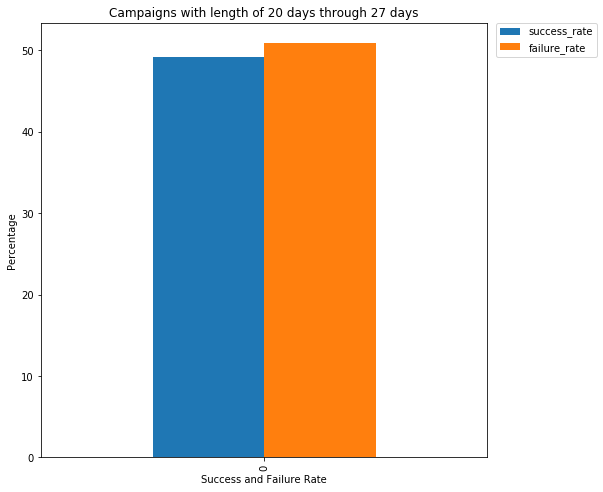

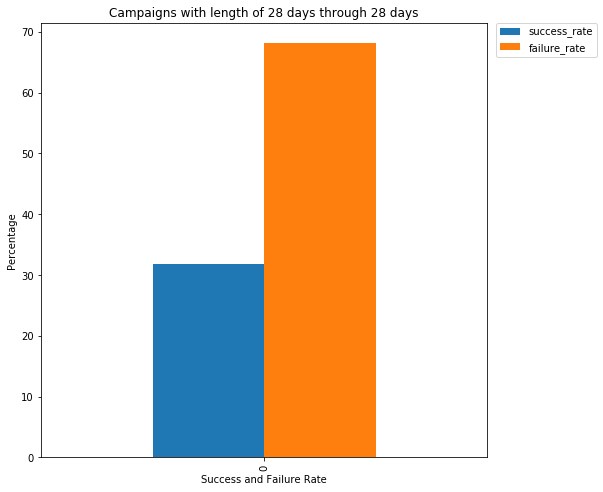

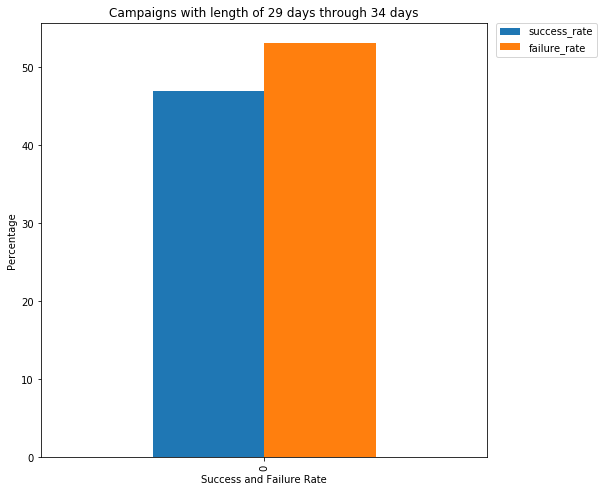

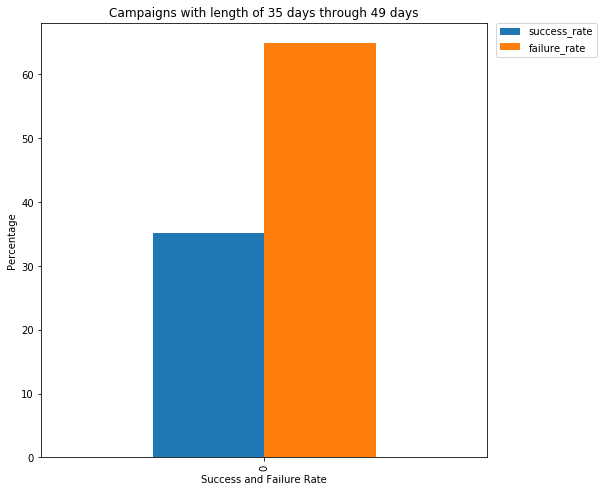

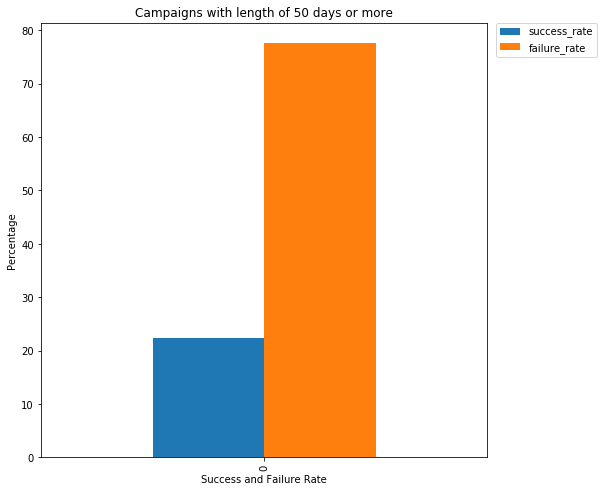

In [139]:
#Give each data point a bin ID based on their assigned bin
length_groups = pd.DataFrame(k_d)
length_bins = [0, 20, 28, 29, 35, 50, 100000]
length_groups['length_group'] = pd.cut(k_d.campaign_length, length_bins, labels=['1','2','3','4','5','6'])

#Iterate through for each bin ID
for i in range(1,7):
    #Create a new dataframe containing only the data points with the bin ID we are currently plotting
    lg = pd.DataFrame(length_groups[length_groups['length_group'] == str(i)])
    #Get the successrate by diving the number of successful data points by the total number of data points
    success_rate = lg['successful'].sum()/lg['ID'].count()
    #Create a new dataframe containing only the success and failure rate
    d = {'success_rate': [success_rate*100], 'failure_rate': [(1-success_rate)*100]}
    sf = pd.DataFrame(d)
    #Plot the success and failure rate on a bar graph
    if i != 6:
        title = 'Campaigns with length of ' + str(length_bins[i-1]) + ' days through ' + str(length_bins[i]-1) + ' days'
    else:
        title = 'Campaigns with length of ' + str(length_bins[i-1]) + ' days or more'
    ax = sf[['success_rate', 'failure_rate']].plot(kind='bar', figsize=(8,8), title=title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
    ax.set_xlabel('Success and Failure Rate')
    ax.set_ylabel('Percentage')

So from this representation we can see that for the bins of 0-19, 20-27, and 29-34, the failure rate is similar at a little over 50% for each bin. This makes sense because we would expect that on average about half of the Kickstarters would fail and half would succeed. But the other bins failure rates are a little more interesting. Looking at just the 35-49 and 50+ bins, we can see that the failure rates in these bins are much higher than the previoous bins, suggesting that Kickstartes with campaign lengths of >35 have a much higher chance to fail then campaigns with lengths <35, with that chance to fail increasing even more for campaigns with lengths of >50.

However, we have to take all the assumptions we've made so far with a grain of salt, because if we look at the failure rate for campaigns with a length of 28 days, we can see that it is substantially higher than we would expect, with a failure rate of about 68%. Based on the sheer number of Kickstarters in this bin we should get a more accurate average failure rate, so this could mean that the actual average failure rate of all Kickstarters should be closer to this bin's failure rate, and all the other bins are innacurate.

Regardless of whether the unexpectedly high failure rate of Kickstarters with a length of 28 days is indicative of innaccuracies in the other bins, it appears to be safe to say that if you want your Kickstarter to be successful, you probably have a better shot by limiting your campaign to less than 35 days, and if you really want the best results it seems that a length of 20-27 days has highest rate of success.

## Monetary Goal vs Failure Rate

Another possible predictor of failure rate is the monetary goal for the campaign, so we would like to see if we should look into a relationship between monetary goal and failure rate. 

In order to do this we decided to take a similar approach to analyzing campaign lenght vs failure rate, by splitting up the dataset into equally sized bins of monetary goal ranges, and comparing the average failure rates of each bin to see if we can find a relationship between monetary goal and failure rate.

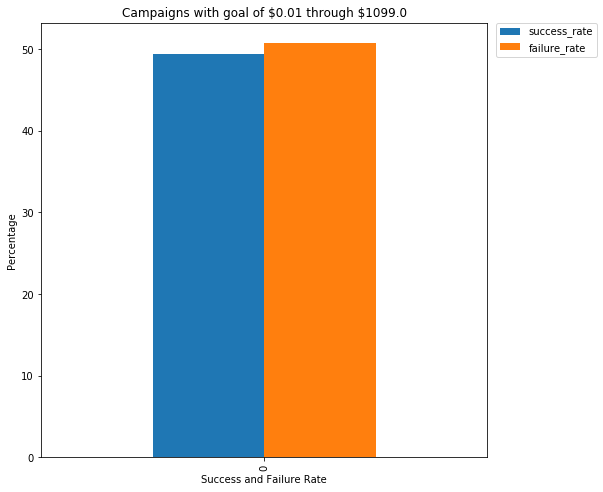

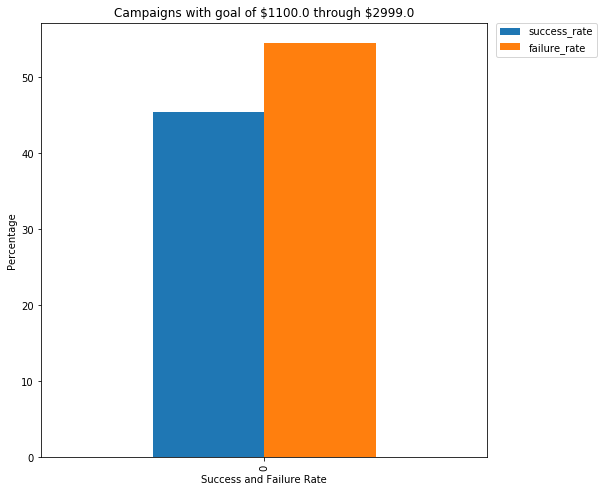

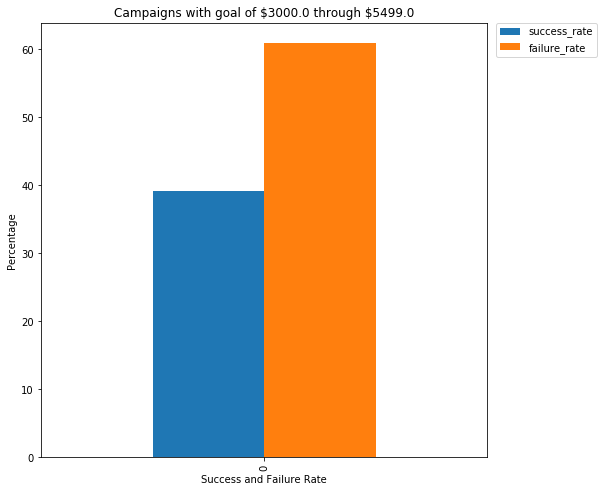

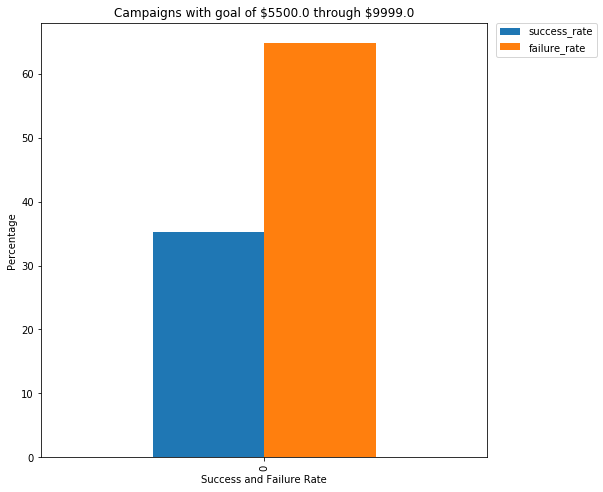

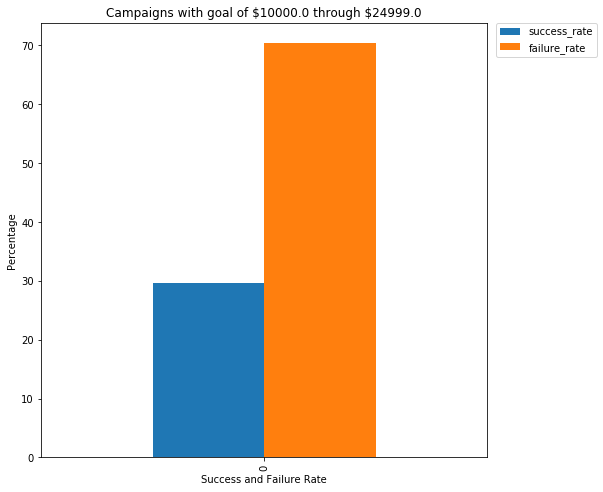

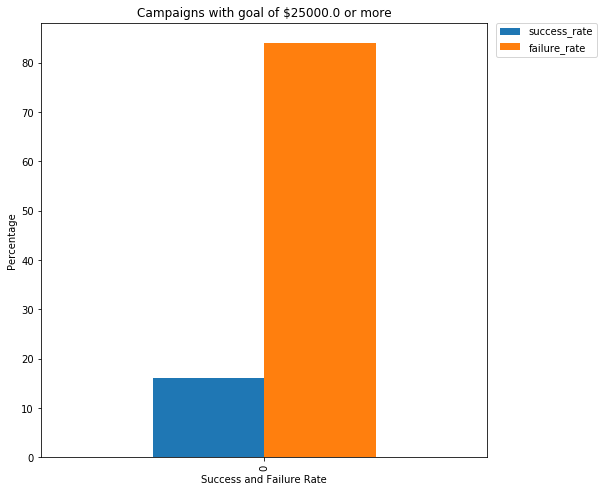

In [140]:
#Give each data point a bin ID based on their assigned bin
money_groups = pd.DataFrame(k_d)
#Get the bin range created by evenly populated bins
s, money_bins = pd.qcut(k_d.usd_goal_real, q=6, labels=['1','2','3','4','5','6'], retbins=True)
money_groups['money_group'] = pd.qcut(k_d.usd_goal_real, q=6, labels=['1','2','3','4','5','6'])

# #Iterate through for each bin ID
for i in range(1,7):
#     #Create a new dataframe containing only the data points with the bin ID we are currently plotting
    lg = pd.DataFrame(money_groups[money_groups['money_group'] == str(i)])
#     #Get the successrate by diving the number of successful data points by the total number of data points
    a = lg['ID'].count()
    success_rate = lg['successful'].sum()/lg['ID'].count()
    #Create a new dataframe containing only the success and failure rate
    d = {'success_rate': [success_rate*100], 'failure_rate': [(1-success_rate)*100]}
    sf = pd.DataFrame(d)
    #Plot the success and failure rate on a bar graph
    if i != 6:
        title = 'Campaigns with goal of \$' + str(money_bins[i-1]) + ' through \$' + str(money_bins[i]-1)
    else:
        title = 'Campaigns with goal of \$' + str(money_bins[i-1]) + ' or more'
    ax = sf[['success_rate', 'failure_rate']].plot(kind='bar', figsize=(8,8), title=title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
    ax.set_xlabel('Success and Failure Rate')
    ax.set_ylabel('Percentage')

Here we can see a clear relationship between monetary goal and failure rate. Looking at the first graph, we see about a 50\% failure rate for Kickstarters with a goal of \\$0.01 to \\$1099. This failure rate increases almost linearly by about 5% for each bin as we increase the monetary goal, with a small jump at the final bin of campaigns with a goal of \\$25,000 or more having a failure rate of more than 80\%. If we think about it this makes sense, as we would expect a lower monetary goal to be more easily attainable, and therefore have a lower failure rate. So from this visualization we can see that monetary goal may be a great candidate for prediciting whether a Kickstarter will fail or succeed.

# Predicting Success Rate of Projects

This section will focus on us attempting to create a model to predict the success rate of a Kickstarter project based off of three given traits, what the category of project is, the length of the campaign for the project, and what the monetary goal of the project is.

First however, since the category of the project is a categorical variable, we must first convert it so that it can properly be included in the model. We will use a technique called [One Hot Encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) to encode the main_category variable into one that can be used to fit the model. Furthermore, we will be using the categories of monetary goals and campaign length that we created above, as there is such a large disparity between campaigns that it would be harder to fit a model.

In [229]:
# Encode the main_catgory column using scikit-learn's LabelEncoder
le = LabelEncoder()
k_d["main_category"] = le.fit_transform(k_d["main_category"])
k_d.head()

,ID,category,main_category,deadline,launched,usd_pledged_real,usd_goal_real,successful,campaign_length,length_group,money_group
0,1000002330,Poetry,12,2015-10-09,2015-08-11 12:12:28,0.0,1533.95,0,58,6,2
1,1000003930,Narrative Film,6,2017-11-01,2017-09-02 04:43:57,2421.0,30000.00,0,59,6,6
2,1000004038,Narrative Film,6,2013-02-26,2013-01-12 00:20:50,220.0,45000.00,0,44,5,6
3,1000007540,Music,10,2012-04-16,2012-03-17 03:24:11,1.0,5000.00,0,29,3,3
4,1000011046,Film & Video,6,2015-08-29,2015-07-04 08:35:03,1283.0,19500.00,0,55,6,5


<br> 
As you have already seen in the section right above and in the exploratory data analysis section, we have already encoded all of the different categorical variables we will be using for this, so all thats left to do is to group them together. We will then add the success_rate where it will be the dependent variable for our regression.

In [210]:
# We first grouped all the projects based on their category_group, length_group, and money_group, we then 
# summed up the total amount of successful projects in each grouping and then counted the total amount of projects
# in each grouping
sum_success = k_d.groupby(['main_category','length_group','money_group'], as_index=False)['successful'].sum()
count_total = k_d.groupby(['main_category','length_group','money_group'], as_index=False)['successful'].count()
success_pct = sum_success.drop(['successful'], axis=1)

# Then add a success rate by divding total successful projects by total projects in that grouping
success_pct['success_rate'] = pd.to_numeric(sum_success['successful']) / pd.to_numeric(count_total['successful'])
success_pct.head()

,main_category,length_group,money_group,success_rate
0,0,1,1,0.599819
1,0,1,2,0.542341
2,0,1,3,0.479478
3,0,1,4,0.358553
4,0,1,5,0.237805


<br>
In order to fit a model, we must first split it into a training and test set, so when the model is being made, the data will be split. Here we will perform this split, create a model and use it to predict the success rate of the projects from the data set based on our three given categories.

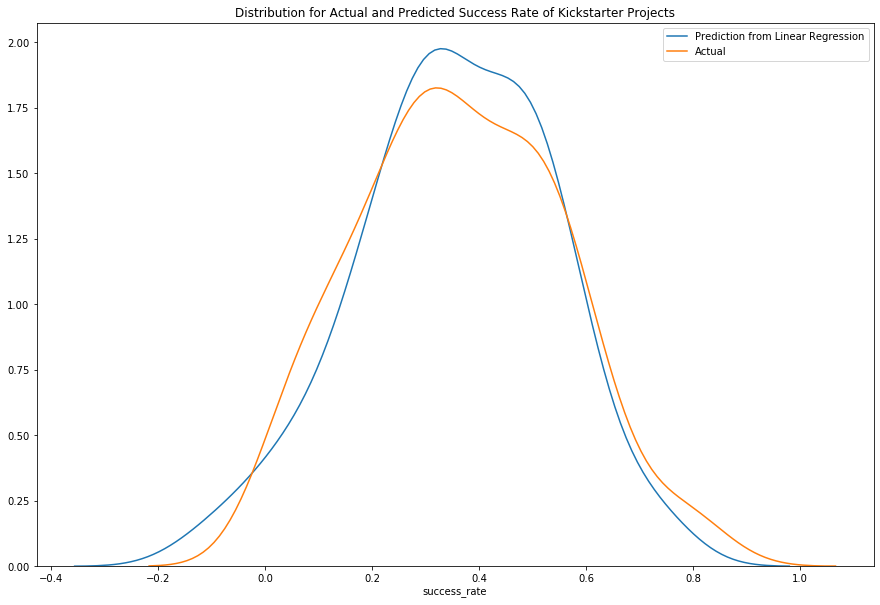

In [226]:
# Split the table into the features(X) and target(y)
X = success_pct.drop(['success_rate'], axis=1)
y = success_pct['success_rate']

#Split the data into training and testing groups
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
X_train['success_rate'] = y_train

# Using the training split to create a linear regression fit and then create a prediction based on X_test group
model = smf.ols(formula='success_rate ~ C(main_category) + C(length_group) + C(money_group)', data=X_train)
model = model.fit()
prediction = model.predict(X_test)

# Plot how the predicted success rate created compares to actual success rate
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Distribution for Actual and Predicted Success Rate of Kickstarter Projects')
sns.distplot(prediction, hist=False, label="Prediction from Linear Regression", ax=ax)
sns.distplot(y_test, hist=False, label="Actual", ax=ax)

plt.show()

As you can see from the graph, it looks like the model does a good job at predicting success rates, as the distributions are quite similar between the actual and predicted. Next, we want to quantify whether or not the model was indeed a good fit. For this we can look at the summary provided by OLS to look at the p-value of the F-statistic to determine goodness of fit for the entire model. For this we are using an alpha of 0.05, meaning that in order for us to assume this is a significant model that the p-value must be below that.

In [228]:
model.summary().tables[0]

Dep. Variable:,success_rate,R-squared:,0.873
Model:,OLS,Adj. R-squared:,0.865
Method:,Least Squares,F-statistic:,101.5
Date:,"Sat, 14 Dec 2019",Prob (F-statistic):,1.55e-142
Time:,01:04:50,Log-Likelihood:,497.04
No. Observations:,378,AIC:,-944.1
Df Residuals:,353,BIC:,-845.7
Df Model:,24,,
Covariance Type:,nonrobust,,


So we can see by looking at the table that the p-value for the F-test for goodness of fit is significantly below the alpha of 0.05 meaning that our model can significantly predict success rates for Kickstarter projects. We can also see that we have a very high R-squared value, meaning that our model was very accurate at predicting success rates (1 being the highest possible score).

# Conclusion